# Traitement d'images avec PIL et Numpy

Ce script Python effectue le chargement et le prétraitement d'images stockées dans une structure de répertoires spécifique. Il utilise les bibliothèques `PIL` (Python Imaging Library) pour le traitement des images et `numpy` pour la manipulation des données d'image. Voici les étapes principales du script :

## Configuration Initiale

- **Chargement des Bibliothèques** : `os` pour interagir avec le système de fichiers, `PIL.Image` et `PIL.ImageFile` pour le traitement d'images, et `numpy` pour la manipulation des données d'image.
- **Paramètre pour Images Tronquées** : `ImageFile.LOAD_TRUNCATED_IMAGES = True` permet de charger des images même si elles sont tronquées ou endommagées.

## Paramètres du Script

- **Chemin du Dossier Principal** : `main_folder_path` définit le chemin d'accès au dossier contenant les images, organisées par classe.
- **Taille Cible des Images** : `target_size` est défini à `(224, 224)`, spécifiant la taille à laquelle toutes les images seront redimensionnées.

## Traitement des Images

- Les listes `image_data` et `labels` sont initialisées pour stocker les données d'image traitées et leurs étiquettes correspondantes.
- Le script parcourt chaque sous-dossier (représentant une classe d'images) dans le dossier principal.
  - Pour chaque image dans ces sous-dossiers :
    - L'image est ouverte, redimensionnée à la `target_size`, convertie en RGB (si nécessaire), et normalisée (les valeurs des pixels sont divisées par 255 pour être entre 0 et 1).
    - L'array d'image résultant est ajouté à `image_data`, et l'étiquette de classe correspondante est ajoutée à `labels`.
- Si une erreur se produit lors du chargement d'une image, le script affiche un message d'erreur mais continue de traiter les autres images.

## Finalisation

- Les listes `image_data` et `labels` sont converties en arrays numpy pour faciliter leur manipulation ultérieure dans des tâches d'apprentissage automatique.


In [3]:
import os
from PIL import Image, ImageFile
import numpy as np


ImageFile.LOAD_TRUNCATED_IMAGES = True


main_folder_path = './test'


target_size = (224, 224)


image_data = []
labels = []


for class_name in os.listdir(main_folder_path):
    class_folder_path = os.path.join(main_folder_path, class_name)
    
    if os.path.isdir(class_folder_path):  
        for image_name in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_name)
            
            try:
                
                with Image.open(image_path) as img:
                    
                    img = img.resize(target_size).convert('RGB')
                    
                    
                    img_array = np.array(img) / 255.0
                    
                    
                    image_data.append(img_array)
                    labels.append(class_name)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")


image_data = np.array(image_data)
labels = np.array(labels)



In [2]:
np.unique(labels)

array(['1', '2', '3', '4', '5', '6'], dtype='<U1')

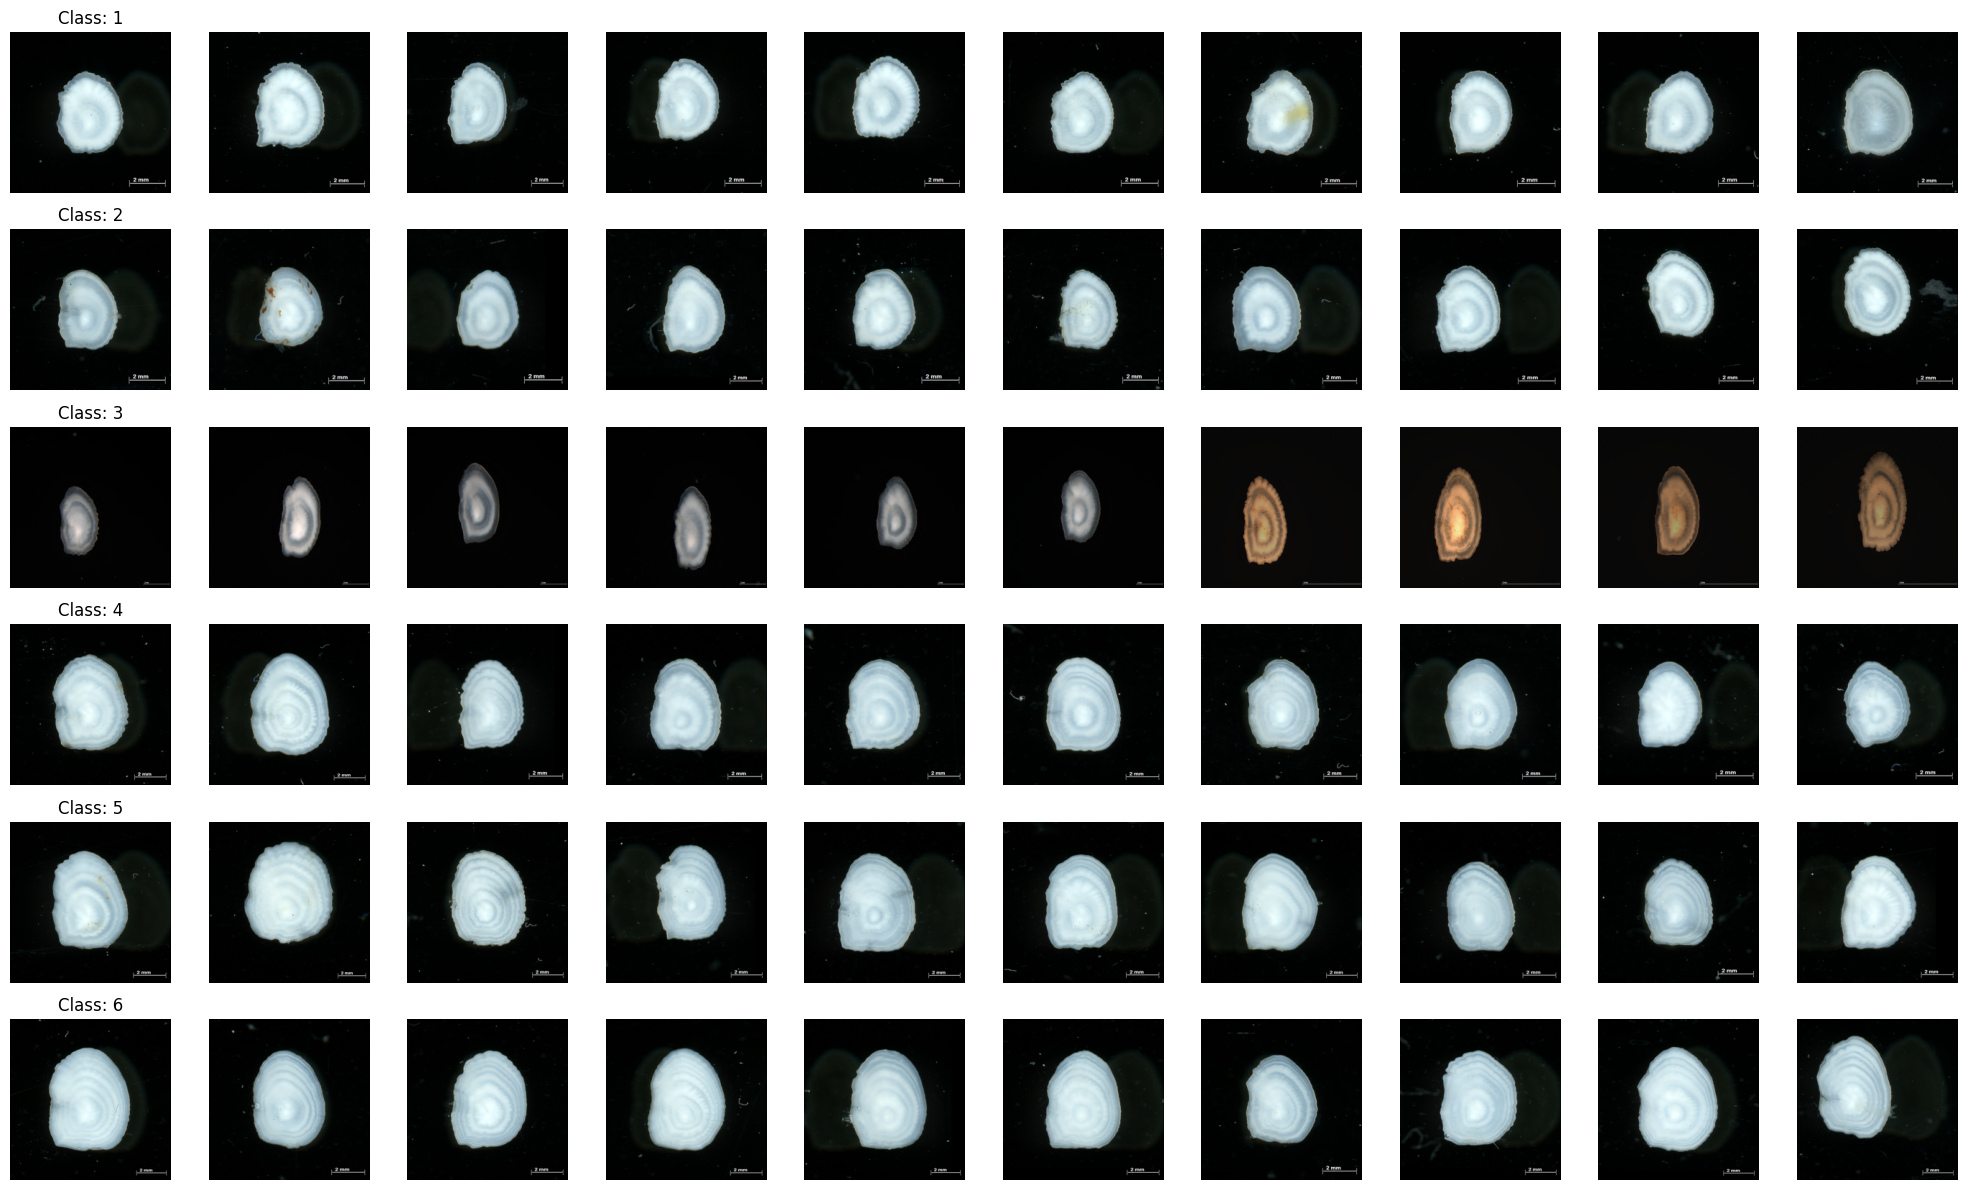

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def display_images_numerically(image_data, labels, num_classes=6, num_images=5):
   
    unique_labels = np.unique(labels)
    sorted_indices = np.argsort([int(label) for label in unique_labels])
    sorted_labels = unique_labels[sorted_indices]
    
    fig, axs = plt.subplots(num_classes, num_images, figsize=(num_images*2, num_classes*2))
    
    for i, label in enumerate(sorted_labels[:num_classes]):
        class_images = image_data[labels == label]
        for j in range(min(num_images, len(class_images))):
            ax = axs[i, j] if num_classes > 1 else axs[j]
            ax.imshow(class_images[j])
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Class: {label}")
    plt.tight_layout()
    plt.show()

display_images_numerically(image_data, labels, num_classes=6, num_images=10)



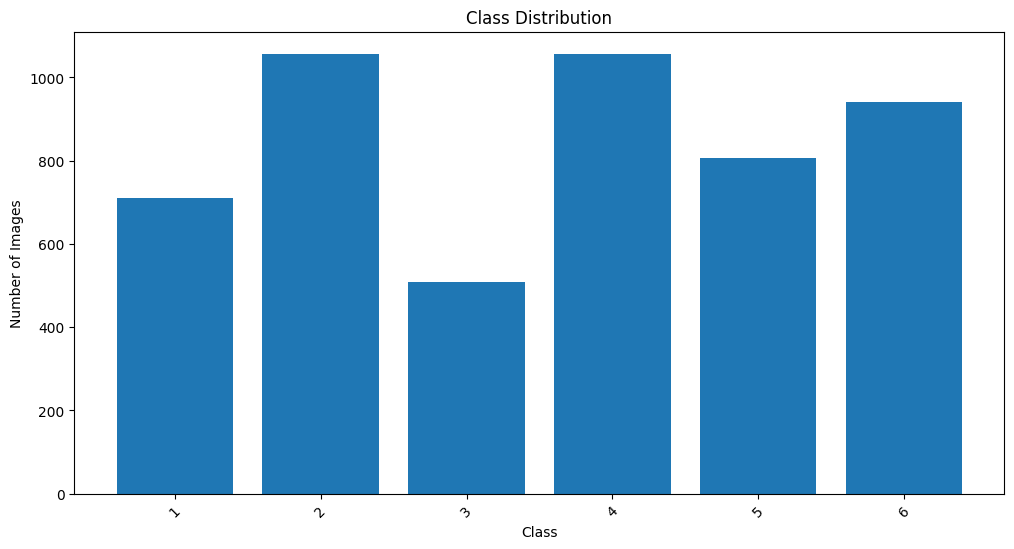

In [5]:
def plot_class_distribution_numerically(labels):

    unique, counts = np.unique(labels, return_counts=True)
    # Sort the classes numerically and their counts accordingly
    sorted_indices = np.argsort([int(label) for label in unique])
    sorted_labels = unique[sorted_indices]
    sorted_counts = counts[sorted_indices]
    
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_labels, sorted_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution_numerically(labels)


# Augmentation des données d'image avec Keras

Ce script étend le traitement des images en utilisant l'augmentation des données pour équilibrer le nombre d'images par classe dans un ensemble de données. Il emploie `ImageDataGenerator` de `tensorflow.keras.preprocessing.image` pour générer dynamiquement des variantes augmentées des images existantes. Voici les étapes clés du processus :

## Configuration de l'Augmentation

- **Importations Nécessaires** : Le script commence par importer `ImageDataGenerator` de Keras pour l'augmentation des images, `numpy` pour la manipulation des arrays, et `mean` de la bibliothèque `statistics` pour le calcul des moyennes.
- **Comptage Cible par Classe** : `target_count_per_class` est calculé comme étant le nombre maximal d'images dans une quelconque des classes. Cela sert de référence pour équilibrer les classes.

## Paramétrage de `ImageDataGenerator`

- Un générateur d'images est configuré avec des paramètres d'augmentation tels que `rotation_range`, `width_shift_range`, `height_shift_range`, `shear_range`, `zoom_range`, `horizontal_flip`, et `fill_mode`. Ces paramètres contrôlent les types de transformations appliquées pour augmenter les données.

## Boucle d'Augmentation

- Pour chaque label unique dans l'ensemble de données :
  - Si le label n'est pas égal à 14, le script procède à l'augmentation.
  - Les images de la classe courante sont sélectionnées.
  - Le nombre d'images à générer (`num_to_augment`) est déterminé par la différence entre `target_count_per_class` et le nombre actuel d'images dans la classe.
  - Si des images doivent être ajoutées pour atteindre `target_count_per_class` :
    - Un mini-batch d'une image est généré à la fois jusqu'à ce que le nombre cible d'images augmentées soit atteint.
    - Les images originales et les nouvelles images augmentées sont ajoutées à `augmented_image_data`.
    - Des labels correspondants sont ajoutés à `augmented_labels` pour chaque image originale et chaque nouvelle image.
  - Si aucune image n'a besoin d'être ajoutée, toutes les images de la classe courante sont simplement ajoutées à `augmented_image_data` avec leurs labels à `augmented_labels`.

## Finalisation

- Les données augmentées et leurs labels sont convertis en arrays numpy.
- Les indices des données augmentées sont mélangés pour assurer une distribution aléatoire.
- Les données et les labels sont réordonnés en fonction des indices mélangés pour garantir que l'ordre des données et des labels correspond.

Cet approche permet de s'assurer que chaque classe dans l'ensemble de données est équitablement représentée, améliorant ainsi la capacité du modèle à apprendre de manière équilibrée à partir de toutes les classes.


In [6]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

import numpy as np
from statistics import mean



target_count_per_class = max(np.unique(labels, return_counts=True)[1])

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_image_data = []
augmented_labels = []

for label in np.unique(labels):
    
    if int(label) != 14:  
        class_images = image_data[labels == label]
        
        num_to_augment = target_count_per_class - class_images.shape[0]
        
        if num_to_augment > 0:
            temp_augmented_images = []
            
            it = datagen.flow(class_images, batch_size=1)
            for _ in range(num_to_augment):
                temp_augmented_images.append(next(it)[0])
                
            augmented_image_data.extend(class_images)
            augmented_image_data.extend(temp_augmented_images)
            
            augmented_labels.extend([label] * (class_images.shape[0] + num_to_augment))
        else:
            augmented_image_data.extend(class_images)
            augmented_labels.extend([label] * class_images.shape[0])

augmented_image_data = np.array(augmented_image_data)
augmented_labels = np.array(augmented_labels)

indices = np.arange(augmented_image_data.shape[0])
np.random.shuffle(indices)
augmented_image_data = augmented_image_data[indices]
augmented_labels = augmented_labels[indices]



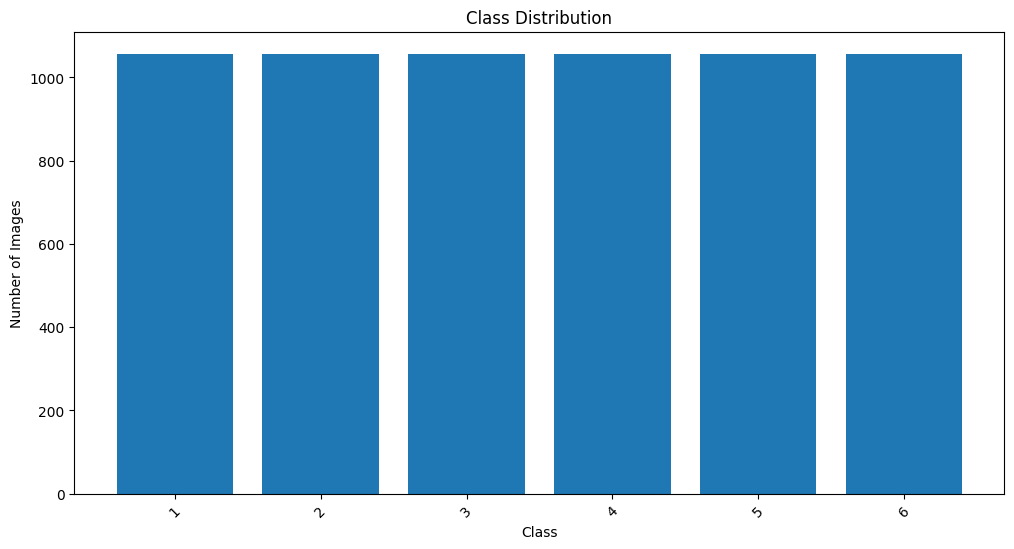

In [7]:
plot_class_distribution_numerically(augmented_labels)

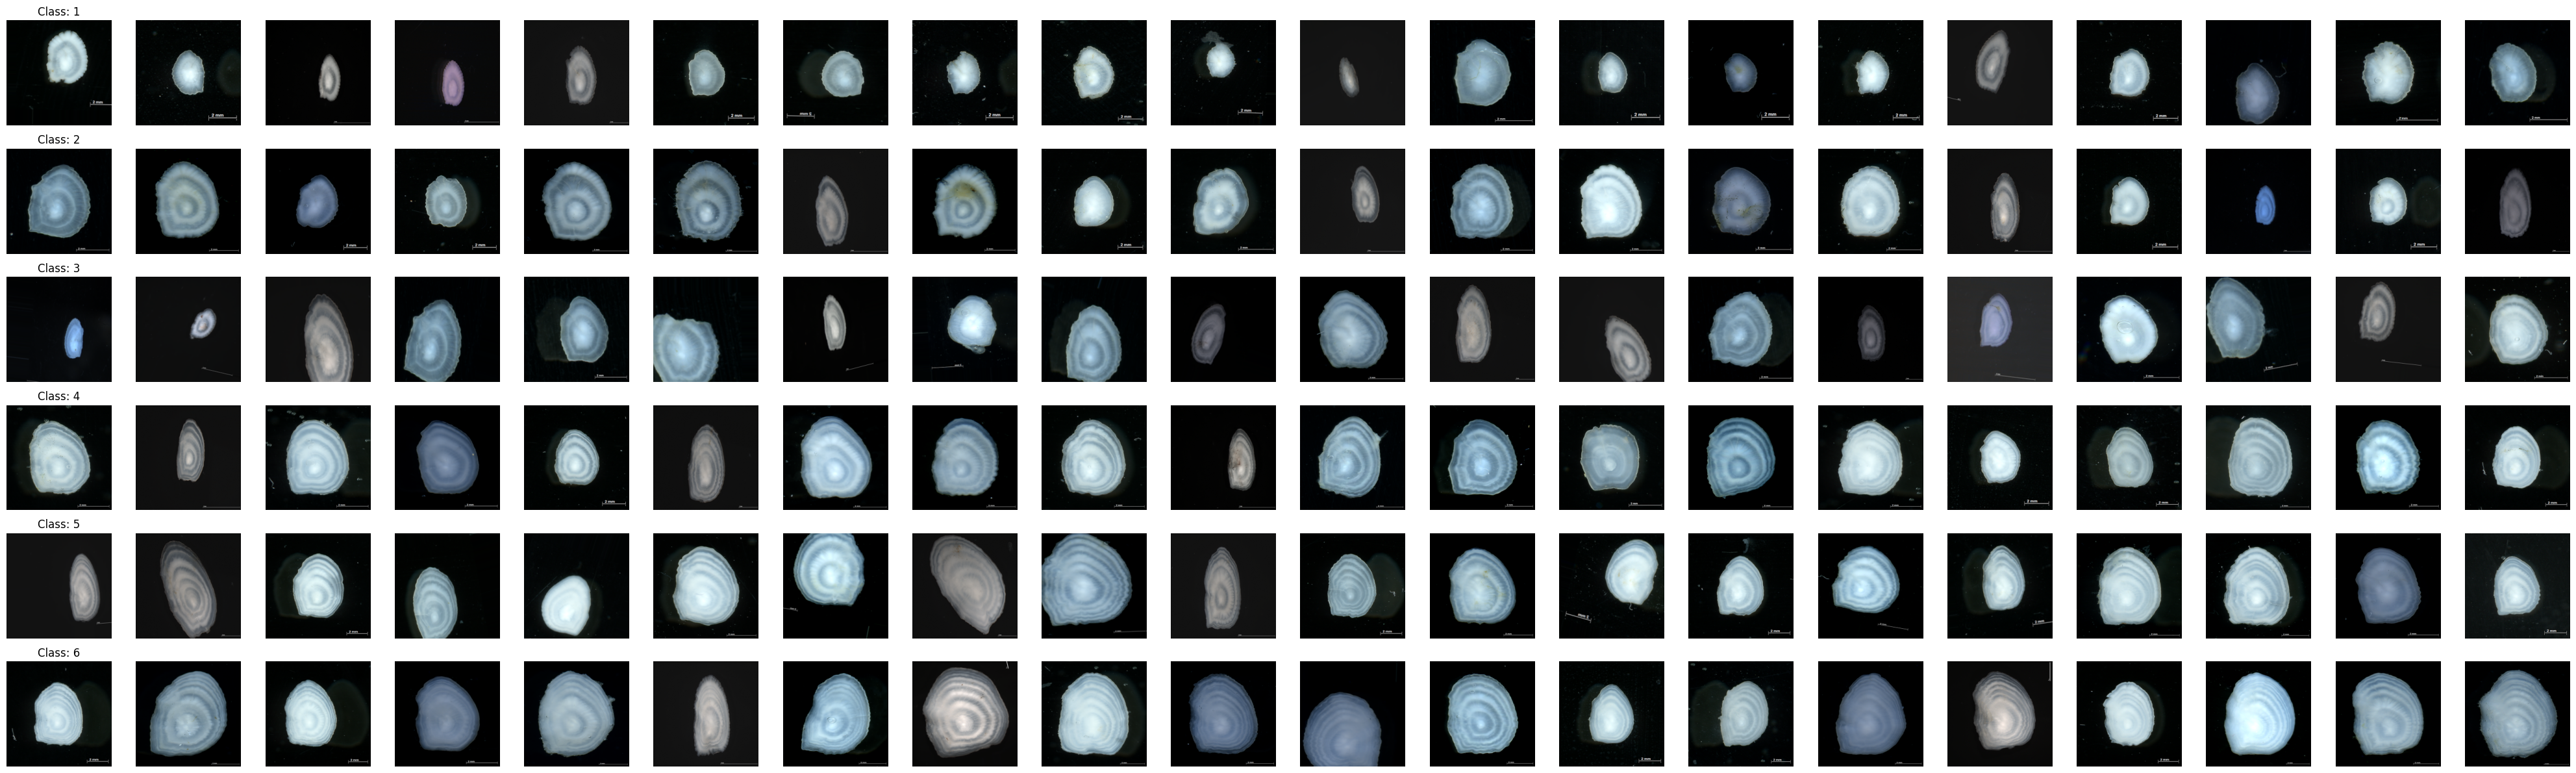

In [8]:
display_images_numerically(augmented_image_data, augmented_labels, num_classes=6, num_images=20)

In [9]:
from sklearn.model_selection import train_test_split

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = [], [], [], []
for label in np.unique(augmented_labels):
    # Sélectionner les indices correspondant à chaque classe
    indices = np.where(augmented_labels == label)[0]
    # Diviser les indices en ensembles d'entraînement et de test
    train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
    # Ajouter les données correspondantes aux ensembles d'entraînement et de test fractionnés
    X_train_balanced.extend(augmented_image_data[train_indices])
    X_test_balanced.extend(augmented_image_data[test_indices])
    y_train_balanced.extend(augmented_labels[train_indices])
    y_test_balanced.extend(augmented_labels[test_indices])

# Conversion des listes en tableaux numpy
X_train_balanced, X_test_balanced = np.array(X_train_balanced), np.array(X_test_balanced)
y_train_balanced, y_test_balanced = np.array(y_train_balanced), np.array(y_test_balanced)

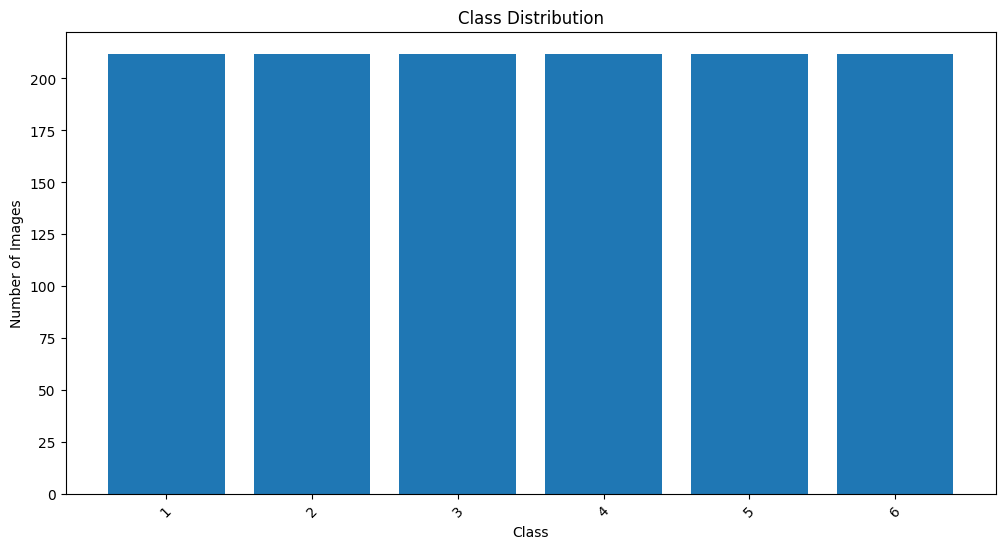

In [10]:
plot_class_distribution_numerically(y_test_balanced)

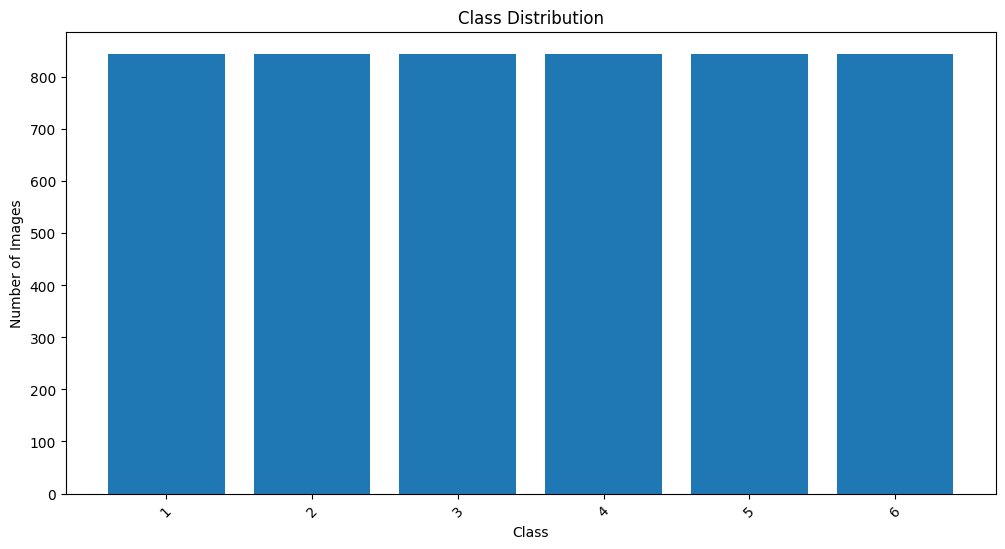

In [11]:
plot_class_distribution_numerically(y_train_balanced)

# Modèle U-Net Modifié pour la Classification d'Images avec TensorFlow et Keras

Ce script définit un modèle basé sur l'architecture U-Net, adapté pour la tâche de classification d'images. L'utilisation de Global Average Pooling (GAP) à la place d'une carte de segmentation en fait un choix efficace pour la classification. Voici une description détaillée des composants et du processus de création du modèle :

## Importations Nécessaires
- `Input`, `Conv2D`, `MaxPooling2D`, `Conv2DTranspose`, `concatenate`, `GlobalAveragePooling2D`, `Dense` de `tensorflow.keras.layers` pour construire le modèle.
- `Model` de `tensorflow.keras.models` pour assembler le modèle.

## Fonction `unet_model_for_classification`
Définit le modèle avec les paramètres suivants :
- `input_size` : La taille des images d'entrée, par défaut à `(224, 224, 3)`.
- `num_classes` : Le nombre de classes pour la classification.

### Architecture du Modèle
1. **Couches Initiales de Convolution et de Pooling** :
   - Des couches `Conv2D` avec activation ReLU et initialisation `he_normal`, suivies par des couches `MaxPooling2D` pour réduire la dimensionnalité.

2. **Upsampling et Concaténation** :
   - `Conv2DTranspose` pour l'upsampling, puis concaténation avec les caractéristiques correspondantes du chemin de descente, suivant l'approche typique de U-Net.

3. **Global Average Pooling (GAP)** :
   - Une couche `GlobalAveragePooling2D` pour réduire chaque carte de caractéristiques à une valeur moyenne, simplifiant la transition vers la classification.

4. **Couche de Classification** :
   - Une couche `Dense` avec activation `softmax` pour la classification finale. Le nombre de neurones correspond au nombre de classes (`num_classes`).

### Compilation du Modèle
- Le modèle est compilé avec l'optimiseur `SGD`, utilisant la perte `categorical_crossentropy` pour un problème de classification multi-classes, et suivant la métrique `accuracy`.

### Création et Résumé
- La fonction `unet_model_for_classification` est appelée pour instancier le modèle.
- `model.summary()` affiche un résumé, montrant l'architecture, y compris les formes de sortie et le nombre de paramètres.

Le modèle résultant est conçu pour classer des images en utilisant les puissantes caractéristiques d'extraction de U-Net, adaptées à travers le GAP pour simplifier les données en vecteurs utiles pour la classification. Ce script montre comment transformer une architecture initialement conçue pour la segmentation d'image en un outil efficace pour la classification d'image.


In [9]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from keras.models import Model

def unet_model_for_classification(input_size=(224, 224, 3), num_classes=6):
    inputs = Input(input_size)
    
    
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    
    
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    
    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    
    
    gap = GlobalAveragePooling2D()(c5)
    
    # Classification layer
    outputs = Dense(num_classes, activation='softmax')(gap)
    print(outputs.shape)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = unet_model_for_classification()
print(model.summary())


(None, 6)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 112, 112,  │      8,224 │ conv2d_2[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 224, 224,  │      2,064 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 224, 224,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 32)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │      4,624 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ conv2d_4[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6)         │        102 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 57,062 (222.90 KB)

 Trainable params: 57,062 (222.90 KB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
#Importing and Scaling data

from  keras import *
#training data
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x  

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model2 = make_model(input_shape=(224,224,3), num_classes=6)
keras.utils.plot_model(model2, show_shapes=True)

epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model2.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def fcn_model(input_shape, num_classes):
    # Entrée du modèle
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder (partie convolutive)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck (partie centrale)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Décodeur (partie de déconvolution)
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    # Couche de sortie
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv5)

    # Création du modèle
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Exemple d'utilisation du modèle
input_shape = (224, 224, 3)  # Taille des images en entrée
num_classes = 6  # Nombre de classes de segmentation (par exemple, poissons et arrière-plan)

model3 = fcn_model(input_shape, num_classes)
model3.summary()


# Encodage et Conversion des Étiquettes pour la Classification avec TensorFlow et Scikit-learn

Ce script illustre le processus d'encodage des étiquettes de texte en valeurs numériques, puis leur conversion en format one-hot pour la classification multi-classes dans des modèles de machine learning, en utilisant `LabelEncoder` de Scikit-learn et `to_categorical` de TensorFlow. Voici un détail des étapes :

## Importations Nécessaires
- `LabelEncoder` de `sklearn.preprocessing` pour convertir des étiquettes textuelles en valeurs numériques.
- `to_categorical` de `tensorflow.keras.utils` pour convertir des valeurs numériques en représentations one-hot.

## Processus d'Encodage
1. **Initialisation de `LabelEncoder`** :
   - Un objet `LabelEncoder` est créé pour gérer la conversion des étiquettes textuelles en numériques.

2. **Encodage des Étiquettes d'Entraînement et de Test** :
   - `y_train_encoded` : Les étiquettes d'entraînement (`label_train`) sont transformées en valeurs numériques uniques pour chaque classe.
   - `y_test_encoded` : De même, les étiquettes de test (`label_test`) sont transformées, en utilisant le même encodage appliqué aux données d'entraînement pour garantir la cohérence.

## Conversion en Format One-Hot
- Après l'encodage en valeurs numériques, les étiquettes sont converties en format one-hot, où chaque classe est représentée par un vecteur contenant un `1` à l'indice correspondant à la classe, et `0` partout ailleurs. Cela permet de traiter les étiquettes comme des probabilités distribuées sur toutes les classes possibles, une approche commune pour la classification multi-classes.
- `y_train_one_hot` et `y_test_one_hot` : Les étiquettes encodées sont converties en format one-hot avec `to_categorical`, spécifiant `num_classes=14` pour indiquer le nombre total de classes distinctes.




In [12]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical




label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)  

y_test_encoded = label_encoder.transform(y_test_balanced) 

y_train_one_hot = to_categorical(y_train_encoded, num_classes=6)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=6)

In [31]:
from keras.models import load_model

model = load_model('./U-net3.h5')

In [17]:
y_train_one_hot

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [11]:

history = model.fit(X_train_balanced, y_train_one_hot, validation_split=0.1, epochs=25, batch_size=32)


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.2013 - loss: 1.8109 - val_accuracy: 0.0000e+00 - val_loss: 1.9685
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.2614 - loss: 1.7701 - val_accuracy: 0.0000e+00 - val_loss: 2.1045
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.2279 - loss: 1.7564 - val_accuracy: 0.0000e+00 - val_loss: 2.1952
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.2359 - loss: 1.7489 - val_accuracy: 0.0000e+00 - val_loss: 2.2720
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.2589 - loss: 1.7380 - val_accuracy: 0.0000e+00 - val_loss: 2.3123
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.2626 - loss: 1.7303 - val_accuracy: 0.0000e+00 - val_loss: 2.3394
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.2846 - loss: 1.7235 - val_accuracy: 0.0000e+00 - val_loss: 2.3418
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.30

In [16]:
hist=model2.fit(X_train_balanced, y_train_one_hot, validation_split=0.1, epochs=25, batch_size=32)

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1275s 9s/step - acc: 0.8339 - loss: 0.4460 - val_acc: 0.8333 - val_loss: 0.6552
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1308s 9s/step - acc: 0.8481 - loss: 0.3440 - val_acc: 0.8333 - val_loss: 0.6102
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1297s 9s/step - acc: 0.8677 - loss: 0.2612 - val_acc: 0.8333 - val_loss: 0.7080
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1246s 9s/step - acc: 0.8747 - loss: 0.2426 - val_acc: 0.8333 - val_loss: 0.5419
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1261s 9s/step - acc: 0.8842 - loss: 0.2259 - val_acc: 1.0000 - val_loss: 0.1168
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1215s 8s/step - acc: 0.8980 - loss: 0.2020 - val_acc: 1.0000 - val_loss: 0.0046
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1260s 9s/step - acc: 0.9033 - loss: 0.1949 - val_acc: 0.8333 - val_loss: 2.0216
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 1276s 9s/step - acc: 0.9081 - loss: 0.1851 - val_acc: 0.8333 - val_loss: 1.6339
Epoch 9/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
history = model3.fit(X_train_balanced, y_train_one_hot, validation_split=0.1, epochs=25, batch_size=32)


In [32]:
from keras.metrics import Precision,Recall,BinaryAccuracy
pre=Precision()
re=Recall()
acc=BinaryAccuracy()
yhat=model.predict(X_test_balanced)


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step


In [33]:
yhat[0]

array([0.60908663, 0.19165643, 0.09924518, 0.03587834, 0.03946629,
       0.02182894, 0.00283822], dtype=float32)

In [35]:
acc.update_state(y_test_one_hot,yhat)

InvalidArgumentError: {{function_node __wrapped__Equal_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [1272,6] vs. [1272,7] [Op:Equal] name: 

In [36]:
acc.result().numpy()*100

0.0

In [37]:
fig=plt.figure()
plt.plot(history.history['accuracy'],color='green',label='accuracy')

fig.suptitle('performance après 25 epochs')
plt.legend(loc="upper left")
plt.show()


NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

In [39]:
###Accuracy per class

def wichclass(y):
    for i in range(6):
        if(y[i]==1):
            return i+1
def wich_pred(y):
    max_p=y[0]
    i_p=0
    for i in range(6):
        if(y[i]>max_p):
            max_p=y[i]
            i_p=i
    return i_p+1


pred_pr_class=[[],[],[],[],[],[],[]]
for i in range(yhat.shape[0]) :
    label_test=wichclass(y_test_one_hot[i])
    label_predict=wich_pred(yhat[i])
    pred_pr_class[label_test-1].append(label_predict)



In [40]:
wich_pred(yhat[1])

1

In [41]:
nbr_pred_par_age=[]
for i in range(len(pred_pr_class)):
    count=0
    for e in pred_pr_class[i]:
        if(e==i+1):
            count=count+1
    nbr_pred_par_age.append(count)


In [42]:
nbr_pred_par_age

[152, 75, 23, 5, 37, 99, 0]

In [43]:
pred_pr_class[2]

[2,
 3,
 5,
 6,
 6,
 3,
 3,
 1,
 3,
 1,
 5,
 3,
 2,
 2,
 2,
 2,
 1,
 5,
 6,
 3,
 1,
 2,
 2,
 6,
 2,
 1,
 6,
 2,
 2,
 6,
 6,
 6,
 2,
 6,
 1,
 4,
 6,
 6,
 6,
 6,
 5,
 6,
 2,
 1,
 1,
 6,
 2,
 2,
 1,
 3,
 2,
 6,
 6,
 3,
 6,
 6,
 3,
 1,
 4,
 2,
 6,
 2,
 6,
 3,
 2,
 6,
 6,
 5,
 2,
 3,
 1,
 5,
 2,
 2,
 6,
 6,
 3,
 1,
 6,
 6,
 4,
 5,
 6,
 5,
 1,
 3,
 6,
 2,
 2,
 5,
 2,
 6,
 1,
 5,
 2,
 6,
 2,
 6,
 2,
 2,
 1,
 2,
 2,
 6,
 2,
 6,
 6,
 6,
 6,
 6,
 1,
 6,
 3,
 2,
 1,
 6,
 2,
 1,
 6,
 6,
 2,
 2,
 2,
 3,
 2,
 1,
 6,
 6,
 3,
 1,
 6,
 6,
 2,
 2,
 4,
 1,
 1,
 2,
 3,
 2,
 3,
 1,
 1,
 4,
 1,
 1,
 6,
 1,
 2,
 2,
 2,
 5,
 3,
 2,
 1,
 6,
 6,
 2,
 6,
 3,
 3,
 2,
 2,
 6,
 2,
 2,
 2,
 5,
 5,
 2,
 3,
 2,
 2,
 6,
 1,
 1,
 5,
 6,
 5,
 6,
 6,
 2,
 2,
 6,
 5,
 2,
 6,
 1,
 6,
 6,
 2,
 1,
 2,
 5,
 2,
 1,
 1,
 6,
 6,
 4,
 6,
 5,
 6,
 3,
 6,
 1,
 2,
 2,
 6,
 2,
 1,
 5]

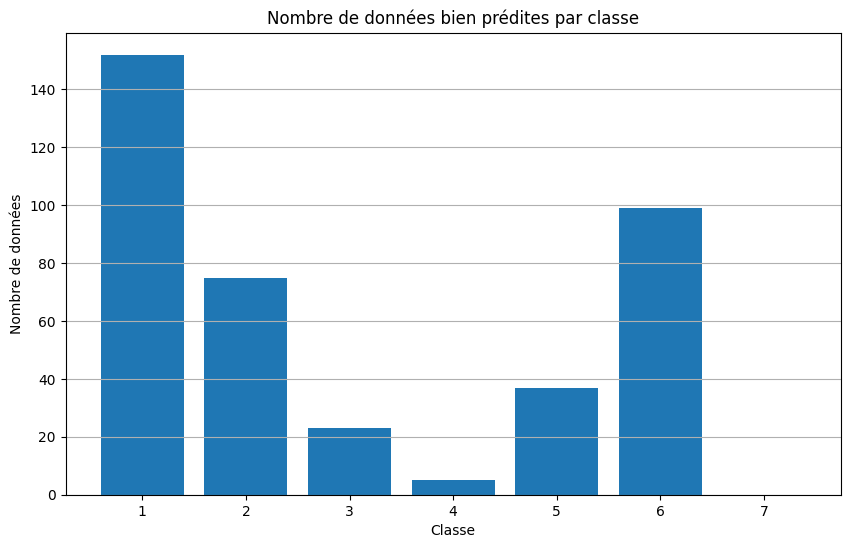

In [44]:
# Plotter l'histogramme des données par classe
classes=[i+1 for i in range(7) ]
plt.figure(figsize=(10, 6))
plt.bar(classes, nbr_pred_par_age, tick_label=classes)
plt.title('Nombre de données bien prédites par classe')
plt.xlabel('Classe')
plt.ylabel('Nombre de données')
plt.grid(axis='y')
plt.show()

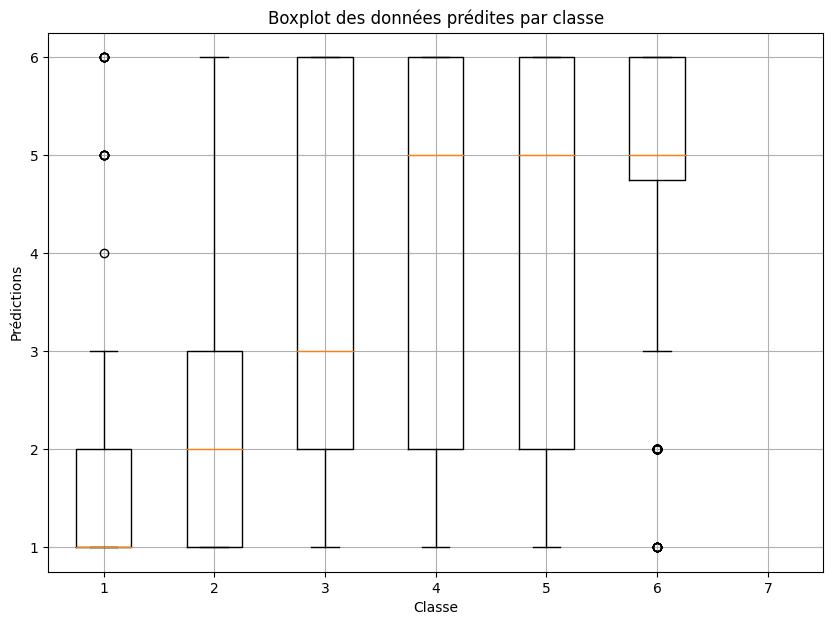

In [45]:
# Tracer les boxplots des données prédites par classe
plt.figure(figsize=(10, 7))
plt.boxplot(pred_pr_class, labels=classes)
plt.title('Boxplot des données prédites par classe')
plt.xlabel('Classe')
plt.ylabel('Prédictions')
plt.grid(True)
plt.show()